## Imports

In [1]:
import numpy as np
import random
import math

## Task

### Rewards

In [3]:
def create_reward_function(probabilities):
    def reward_function(action):
        return 1 if np.random.rand() < probabilities[action-1] else 0

    return reward_function

### Policies

Random:

In [4]:
def random_bandit_policy(num_actions):
    actions = range(1, num_actions + 1)
    action = random.choice(actions)

    return action

Epsilon greedy:

In [38]:
def epsilon_greedy_policy(q_values, epsilon):
    num_actions = len(q_values)

    if np.random.rand() < epsilon:
        action = np.random.choice(num_actions)  # Explore
    else:
        action = np.argmax(q_values)  # Exploit (pick the action with the highest Q-value)

    action += 1

    return action

UCB:

In [12]:
def ucb_policy(q_values, action_counts, total_steps, c=1):
    num_actions = len(q_values)
    ucb_values = [0] * num_actions
    
    for i in range(num_actions):
        if action_counts[i] > 0:
            exploitation = q_values[i]
            exploration = c * np.sqrt(np.log(total_steps + 1) / action_counts[i])
            ucb_values[i] = exploitation + exploration
        else:
            ucb_values[i] = float('inf')  # Force exploration if action hasn't been taken yet

    action = np.argmax(ucb_values) + 1

    return action

Thompson Sampling:

In [13]:
def thompson_sampling_policy(action_successes, action_failures):
    num_actions = len(action_successes)
    samples = [np.random.beta(action_successes[i] + 1, action_failures[i] + 1) for i in range(num_actions)]
    
    action = np.argmax(samples) + 1

    return action

## Agent

In [39]:
class RL_Agent:
    def __init__(self, num_actions, action_reward_probs, policy, epsilon=None, c=1):
        self.num_actions = num_actions
        self.action_reward_probs = action_reward_probs

        self.reward_function = create_reward_function(action_reward_probs)

        self.policy = policy

        self.c = c  # Exploration parameter for UCB policy
        
        self.epsilon = epsilon  # for epsilon greedy policy
        self.epsilon_decay_rate = 0.998  # Decay rate for epsilon
        self.min_epsilon = 0.05  # Minimum epsilon value
        self.epsilons = []

        self.q_values = np.zeros(num_actions) 
        self.action_counts = np.zeros(num_actions)

        self.rewards = []
        self.regrets = []

        self.action_successes = np.zeros(num_actions)
        self.action_failures = np.zeros(num_actions)
    
    def take_action(self, step):
        match self.policy:
            case "random bandit":
                return random_bandit_policy(self.num_actions)

            case "epsilon greedy":
                # Decay epsilon over time
                self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay_rate)
                self.epsilons.append(self.epsilon)
                
                return epsilon_greedy_policy(self.q_values, self.epsilon)

            case "ucb":
                return ucb_policy(self.q_values, self.action_counts, step, self.c)

            case "thompson sampling":
                return thompson_sampling_policy(self.action_successes, self.action_failures)
    
    def receive_reward(self, action):
        reward = self.reward_function(action)
        self.rewards.append(reward)
        return reward
    
    def update_q_values(self, action, reward):
        self.action_counts[action-1] += 1
        self.q_values[action-1] += (reward - self.q_values[action-1]) / self.action_counts[action-1]

        if reward == 1:
            self.action_successes[action-1] += 1
        else:
            self.action_failures[action-1] += 1

        self.calculate_regret(reward)

    def calculate_regret(self, reward):
        best_action = np.argmax(self.action_reward_probs)
        best_reward = self.action_reward_probs[best_action]
        regret = best_reward - reward
        self.regrets.append(regret)

## Run

In [33]:
def run(num_steps, agents):
    for step in range(num_steps):
        actions = [agent.take_action(step) for agent in agents]
        rewards = [agent.receive_reward(action) for agent, action in zip(agents, actions)]

        for agent, action, reward in zip(agents, actions, rewards):
            agent.update_q_values(action, reward)
    
    return [agent.rewards for agent in agents], [agent.regrets for agent in agents]

In [28]:
def cumulating(X):
    sum_X = []
    for i in range(len(X)):
        sum_X.append([])
        for j in range(len(X[i])):
            sum_X[i].append(sum(X[i][0:j]))
    return sum_X

In [17]:
num_actions = 6 # (569%5) + 2

action_reward_probs = [.1, .9, .9, .5, .6, .9] # 1, otherwise 0

policies = ["thompson sampling", "ucb", "epsilon greedy"]

epsilon = 0.5

In [34]:
num_steps = 5000

agents = [
    RL_Agent(
        num_actions=num_actions,
        action_reward_probs=action_reward_probs,
        policy=policies[i], 
        epsilon=epsilon,
        c=1
    ) for i in range(len(policies))]

rewards, regrets = run(num_steps, agents)

In [35]:
c_rewards = cumulating(rewards)
c_regrets = cumulating(regrets)

## Plots

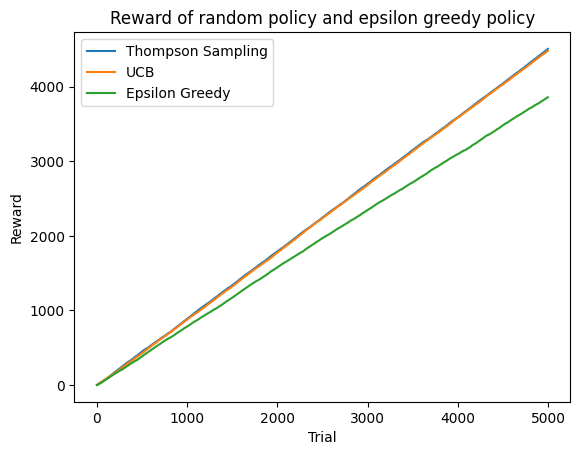

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(c_rewards[0], label="Thompson Sampling")
ax.plot(c_rewards[1], label="UCB")
ax.plot(c_rewards[2], label="Epsilon Greedy")

# ax.plot(agents[0].epsilons, label="epsilon")

# Set the title and labels
ax.set_title("Reward of random policy and epsilon greedy policy")
ax.set_xlabel("Trial")
ax.set_ylabel("Reward")
# Show the plot
plt.legend()
plt.show()

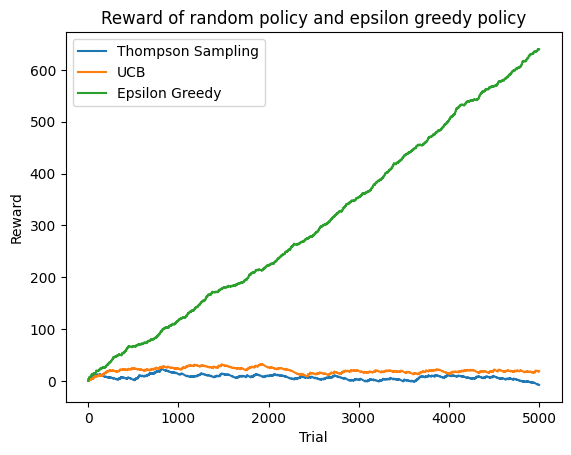

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# ax.plot(c_rewards[0], label="Thompson Sampling")
# ax.plot(c_rewards[1], label="UCB")
# ax.plot(c_rewards[2], label="Epsilon Greedy")

ax.plot(c_regrets[0], label="Thompson Sampling")
ax.plot(c_regrets[1], label="UCB")
ax.plot(c_regrets[2], label="Epsilon Greedy")

# ax.plot(agents[0].epsilons, label="epsilon")

# Set the title and labels
ax.set_title("Reward of random policy and epsilon greedy policy")
ax.set_xlabel("Trial")
ax.set_ylabel("Reward")
# Show the plot
plt.legend()
plt.show()